## Procedural Sketches

In [70]:
## Prelude
#------------------------

using Images, Colors, Lazy, StaticArrays;

function LAB➜RGB(color)
    convert(RGB{Float64}, Lab(color...))::RGB{Float64}
end


function createImage(shader::Function, w=400, h=400)
    img = Array{RGB{Float64}, 2}(undef, h, w)
	@Threads.threads for j=h:-1:1
		for i=1:w
			img[h-j+1,i] = LAB➜RGB(shader(i,j,w,h))
		end
	end
	img
end
nothing

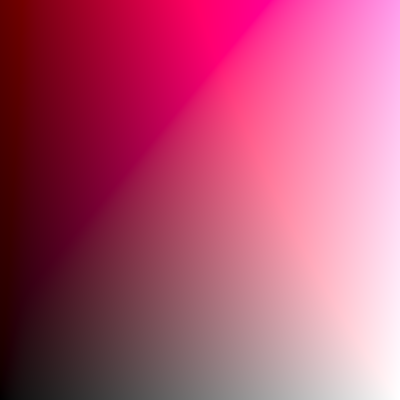

In [71]:
## small steps
function sweep(hue) 
    hr = deg2rad(hue) 
    c  = cos(hr)
    s  = sin(hr)
    (i,j,w,h) -> [100*i/w, 100*j/h*c, 100*j/h*s]
end
    
createImage(sweep(7)) 


## Warps and Wefts

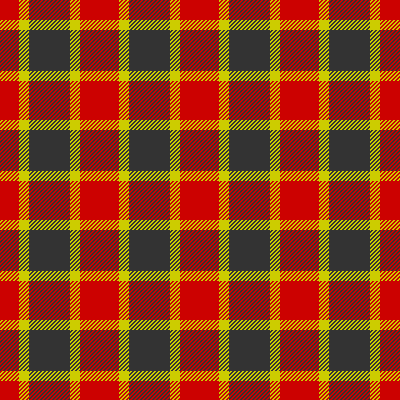

In [72]:
red    = (42.5, 67.6, 56.7)
yellow = (79.6,-18.1, 79.8)
grey   = (21.2,  0.0,  0.0)

createImage() do i,j,w,h
    threadCount=100
    thread = mod(i-j,4) < 2           ? i % threadCount      : j % threadCount ## 2/2 twill
    thread = thread > threadCount/2   ? threadCount - thread : thread          ## symmetrize
    color  = thread < 0.2*threadCount ? red    : 
             thread < 0.3*threadCount ? yellow :                 
                                        grey                    
end

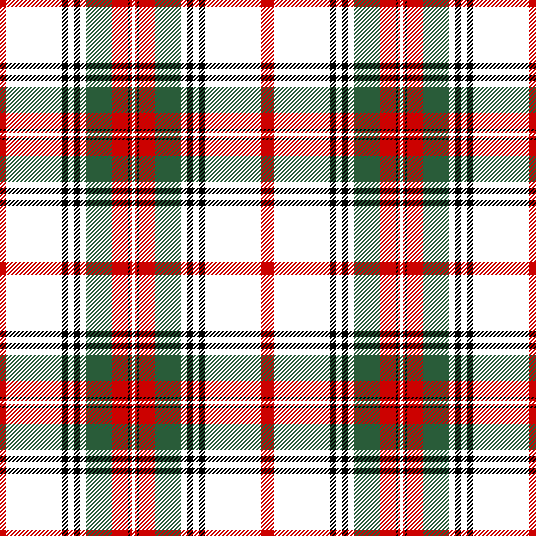

In [73]:
## an infamous pattern: "ye principal clovris of ye clanne Stewart"
## R6 W56 Bk6 W6 Bk6 W6 g26 R16 Bk2 R2 W2
red   = ( 42.5, 67.6, 56.7)
white = (100.0,  0.0,  0.0)
green = ( 35.0,-26.1, 15.1) #dark green
black = (  0.0,  0.0,  0.0)
stewart=(( 6, red   ) , 
         (56, white ) ,
         ( 6, black ) ,
         ( 6, white ) ,
         ( 6, black ) ,
         ( 6, white ) ,
         (26, green ) ,
         (16, red   ) ,
         ( 2, black ) ,
         ( 2, red   ) ,
         ( 2, white ) ,)

function tartan(sett)
    counts   = [x[1] for x=sett]
    colors   = [x[2] for x=sett]
    cumCount = cumsum(counts)
    threadCount = 2*sum(counts);
    (i,j,w,h) -> begin
        thread = mod(i-j,4) < 2 ? i % threadCount : j % threadCount       ## 2/2 twill
        thread = thread > threadCount/2 ? threadCount - thread : thread   ## symmetrize the pattern
        colors[findfirst(thread .<= cumCount)]           ## lookup color
    end
end

createImage(tartan(stewart),536,536)

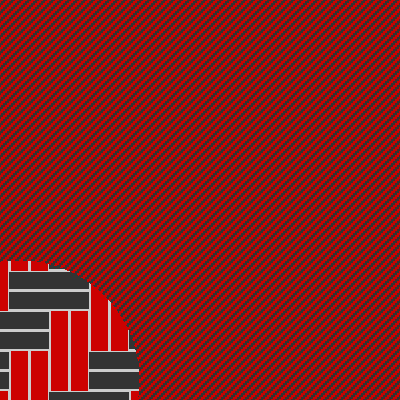

In [77]:
## weave
function weave(isWeftOnTop::Function, color::Function; threadWidth=1.0,margin=0.10, marginColor=[82.0, 0, 0])
    (i,j,w,h) -> begin
        i = i+0.5; j = j+0.5;  ##  №, I am not ☆ about this ❆
        (weftId, weftRem)  = divrem(i,threadWidth)
        (warpId, warpRem)  = divrem(j,threadWidth)            
        weftOnTop = isWeftOnTop(weftId, warpId) 
        remainder = weftOnTop ? weftRem : warpRem
        fraction = remainder/threadWidth
        fraction = fraction >= 0.5 ? 1.0-fraction : fraction ## symmetrize
        fraction >= margin ? color(weftOnTop,weftId,warpId) : marginColor  
    end
end

## zoom
function zoom(shader::Function; center=SA[20.0,20.0], radius=120.0, scale=20.0)
    (i,j,w,h) -> begin
        p = SA[i,j]
        s = norm(p-center) < radius ? scale : 1.0
        p = center + (p-center)/s
        shader(p[1], p[2],w,h)
    end
end

simpleColors(isWeftOnTop, i, j) = isWeftOnTop ?  red : grey
twill = (i,j) -> mod(i-j,4) < 2
widen(f, n) = (i,j) -> f(floor(Int, i/n), floor(Int, j/n))

@> twill begin          ## @> is a threading macro from Lazy    
   widen(2)
   weave(simpleColors) 
   zoom 
   createImage 
end
    

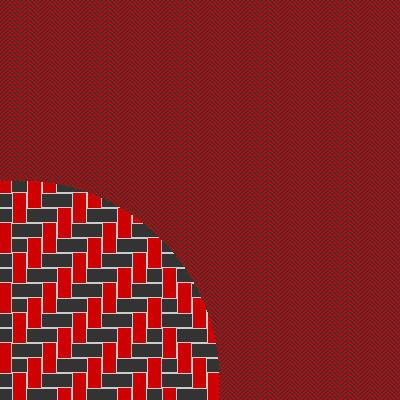

In [78]:
#todo

begin
		
	function herring(i,j)
		n = 20
		x = mod(i, n)
		(x <  n/2) ? mod(i-j,4) < 2 : mod(i+j,4) < 2  
		
		#mod(x, 2) == 0
	end
	
	@> herring begin          ## @> is a threading macro from Lazy    
	   weave(simpleColors) 
	   #(f) -> (i,j,w,h) -> f(floor(Int, i/3), floor(Int, j/3), w, h)	
	   zoom(scale=15,radius=200) 
	   createImage 
	end
end

In [82]:
g = @> twill begin          ## @> is a threading macro from Lazy    
   widen(3)
   weave(simpleColors) 
   zoom 
end

@show @code_native  g(1,2,3,4)

@show @code_llvm  g(1,2,3,4)


	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[77]:17 within `#272`
	subq	$8, %rsp
; │ @ In[77]:19 within `#272`
; │┌ @ linalg.jl:16 within `-`
; ││┌ @ mapreduce.jl:37 within `map`
; │││┌ @ mapreduce.jl:40 within `_map`
; ││││┌ @ mapreduce.jl:75 within `macro expansion`
; │││││┌ @ promotion.jl:381 within `-`
; ││││││┌ @ promotion.jl:350 within `promote`
; │││││││┌ @ promotion.jl:327 within `_promote`
; ││││││││┌ @ number.jl:7 within `convert`
; │││││││││┌ @ float.jl:146 within `Float64`
	vcvtsi2sd	%rsi, %xmm0, %xmm0
; ││││││└└└└
; ││││││ @ promotion.jl:381 within `-` @ float.jl:402
	vmovsd	(%rdi), %xmm1                   ## xmm1 = mem[0],zero
	vmovsd	8(%rdi), %xmm2                  ## xmm2 = mem[0],zero
	vsubsd	%xmm1, %xmm0, %xmm0
; ││││││ @ promotion.jl:381 within `-`
; ││││││┌ @ promotion.jl:350 within `promote`
; │││││││┌ @ promotion.jl:327 within `_promote`
; ││││││││┌ @ number.jl:7 within `convert`
; │││││││││┌ @ float.jl:146 within `Float64`
	vcvtsi2sd	%rdx, %xmm3, %x

; │││┌ @ /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/generic.jl:493 within `norm_sqr`
; ││││┌ @ number.jl:177 within `abs2`
; │││││┌ @ float.jl:405 within `*`
        %13 = fmul double %8, %8
        %14 = fmul double %12, %12
; │││└└└
; │││┌ @ float.jl:399 within `+`
      %15 = fadd double %13, %14
; │││└
; │││┌ @ math.jl:568 within `sqrt`
      %16 = call double @llvm.sqrt.f64(double %15)
; └└└└
  %17 = getelementptr inbounds { [1 x [2 x double]], double, double, { double, double, {}*, { i64 } } }, { [1 x [2 x double]], double, double, { double, double, {}*, { i64 } } }* %0, i64 0, i32 1
; ┌ @ float.jl:444 within `<`
   %18 = load double, double* %17, align 8
   %19 = fcmp uge double %16, %18
; └
  %20 = getelementptr inbounds { [1 x [2 x double]], double, double, { double, double, {}*, { i64 } } }, { [1 x [2 x double]], double, double, { double, double, {}*, { i64 } } }* %0, i64 0, i32 2
  %21 = load double, double* %20, align 8


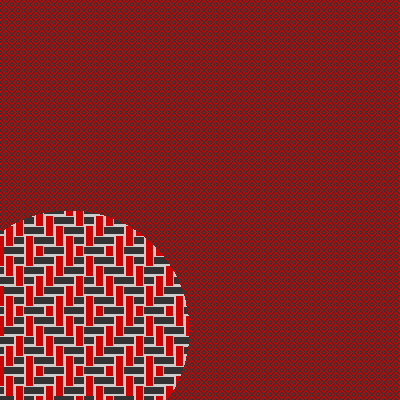

In [22]:
function escherDiamonds(size) 
    (i,j) -> begin
        op = mod(div(i,size) + div(j,size),2) == 0 ? (+) : (-)
        mod(op(i,j),4) < 2 
    end
end

@> escherDiamonds(6.0) begin 
   weave(simpleColors) 
   zoom(center=[70.0,70.0], scale=10.0) 
   createImage
end


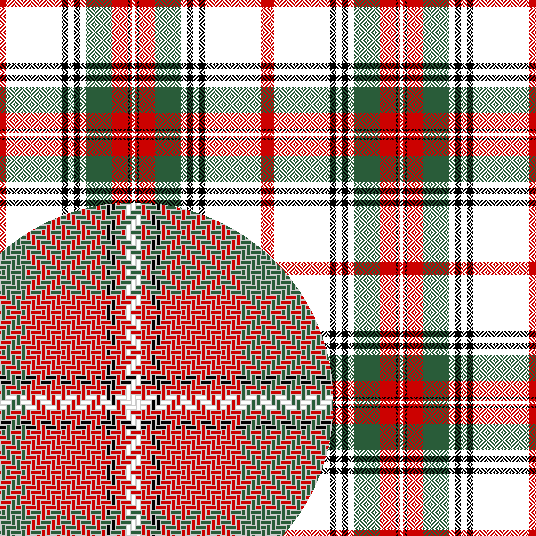

In [23]:

function settColors(sett)
    counts   = [x[1] for x=sett]
    colors   = [x[2] for x=sett]
    cumCount = cumsum(counts)
    threadCount = 2*sum(counts);
    (weftOnTop,i,j) -> begin
        thread = weftOnTop ? i % threadCount : j % threadCount           
        thread = thread > threadCount/2 ? threadCount - thread : thread   ## symmetrize the pattern
        vec(colors[findfirst(thread .<= cumCount)])                       ## lookup color
    end
end


@> escherDiamonds(8) begin
   weave(settColors(stewart))
   zoom(center=[134,134], radius=200.0, scale=5.0) 
   createImage(536,536)
end



## On to Geometry

In [24]:
## LAB is great space for blending colors
## but LCHab is a nice for creating pretty palettes
function LCHab➜LAB(color) ## lifted from Color.jl
    hr = deg2rad(color[3])
    [color[1], color[2] * cos(hr), color[2] * sin(hr)]
end
nothing

In [25]:
# Some helpers 

## makes (x,y) = (0.0,0.0) center of image
## width of image is x=-1.0..1.0
## preserves aspect ratio
function xy(i,j,w,h)
    ((2.0(i-1)-w)/w,
     (2.0(j-1)-h)/w) # div by w is not a typo
end

## Some favorites from GLSL
function clamp(v, low, hi)
    v > hi   ? hi  :
    v < low  ? low :
    isnan(v) ? hi  : v
end

## A "smooth" step function
function smoothstep(edge0, edge1, x)
    t = clamp((x - edge0) / (edge1 - edge0), 0.0, 1.0);
    t * t * (3.0 - 2.0 * t)
end

## Color mixer
function mix(c1, c2, amount)
    other = 1.0-amount
    c1*other + c2*amount
end

mix (generic function with 1 method)

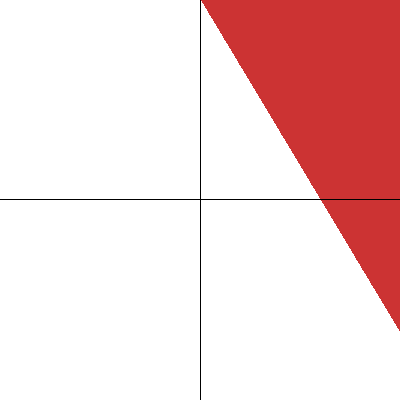

In [26]:
foreground = LCHab➜LAB([ 46.2,69.8,32.1])
background = [100.0, 0.0, 0.0]

## a half-plane
createImage(400,400) do i,j,w,h
    (x,y) = xy(i,j,w,h)
    plane = 5x + 3y - 3
    
    color = plane > 0 ? foreground : background
    
    axis = 0.001
    color = abs(x) < axis || abs(y) < axis ? [0.0, 0.0, 0.0] : color  ## add axis
end

## note the jaggies at the border...

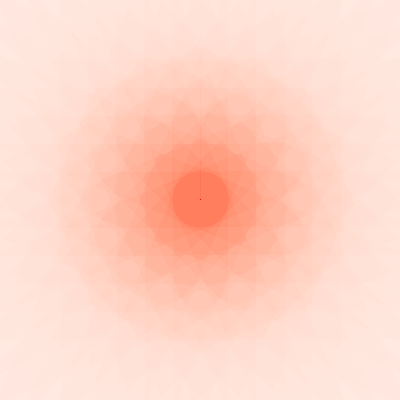

In [28]:
# A slight detour into the wonderful world of half planes

pattern(;m=10,n=20,maxoffset=0.8) = begin
    θ = 2π/n 
    c = cos(θ)
    s = sin(θ)
    increment=5.0/(n*m) ## hack
    
    ## test if each pixel is within n*m half-planes
    ## for n orientations and m offsets from the origin 
    (i,j,w,h) -> begin
        (x,y) = xy(i,j,w,h)
        blend = 0.0
        color = [53.2 , 80.0, 67.2]
        fore  = [100.0,  0.0,  0.0]
        
        for offset=LinRange(0,maxoffset,m)
            a,b = (1.0,0.0) #initial plane orientation
            for ii=1:n
                inPlane = a*x + b*y - offset > 0.0
                blend = inPlane ? increment : 0.0
                color = mix(color,fore,blend)
                ##rotate the plane
                temp = c*a - s*b
                b    = s*a + c*b
                a    = temp
            end
        end
        color
    end
end

@> pattern(m=6,n=16,maxoffset=0.7) createImage(400,400) 

# A cosmic space areola

## Lets fix those Jaggies

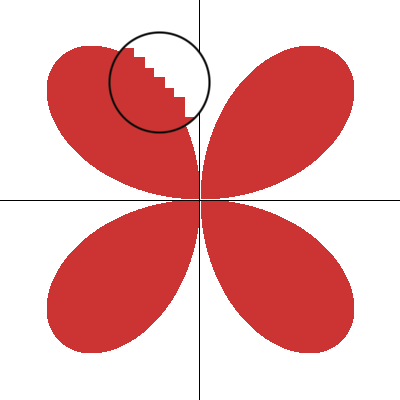

In [29]:
function zoomPixels(shader::Function;center=[20,20],radius=30.0,scale=10.0)
    (i,j,w,h) -> begin
        p = [i,j]
        distance = norm(p-center)
        s =  distance < radius ? scale : 1.0
        p = center + (p-center)/s
        color = shader(round(p[1]),round(p[2]),w,h)  ## note the "round"
        mix(color,[0.0,0.0,0.0],1.0-smoothstep(0.0, 2.0, abs(radius-distance))) ## add a ring
    end
end

function shape(f::Function,fore,back) 
    (i,j,w,h) -> begin
        (x,y) = xy(i,j,w,h)
        r = f(x,y) ## r==0 defines the boundary of the shape
        color = r < 0.0 ? fore : back
    end
end

function axis(shader::Function,axisColor=[0.0,0.0,0.0]) 
    (i,j,w,h) -> begin
        abs(i-w/2)<1 || abs(j-h/2)<1 ? axisColor : shader(i,j,w,h) 
    end
end

red   = LCHab➜LAB([ 46.2,69.8,32.1])
white = [100.0, 0.0, 0.0]

rose(x,y) = (x^2 + y^2)^3 - 4x^2*y^2

@> rose begin 
    shape(red, white) 
    axis
    zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage
end


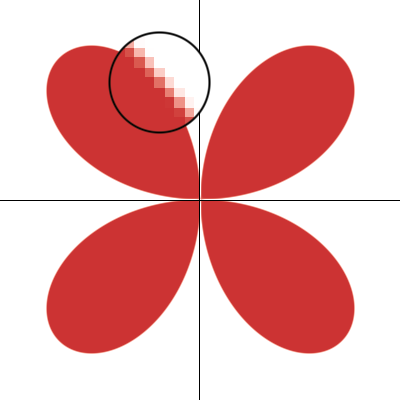

In [30]:
## by hand (for now...) 
drose_dx(x,y) = 2x*(3*(x^2 + y^2)^2 - 4y^2)
drose_dy(x,y) = drose_dx(y,x)

## differentials of x and y versus pixel coords
function dxy(i,j,w,h)
    [2.0/w 0.0; 0.0 2.0/w]  ## div by w is not a typo
end

function smoothShape(funcs,fore,back) 
    (f,dfdx,dfdy) = funcs
    (i,j,w,h) -> begin
        (x,y) = xy(i,j,w,h)
        dxy_dij = dxy(i,j,w,h)
        r = f(x,y)  ## r==0 defines the boundary of the shape
        dr_dxy = [dfdx(x,y) ; dfdy(x,y)]
        dr_dij = dxy_dij*dr_dxy
        r_in_pix = r/norm(dr_dij)
        color = mix(fore,back,smoothstep(-1.0, 1.0, r_in_pix)) 
        ## 1.0 pixel is the magic number -- try 0.5 or 2.0 if you don't believe me 
        ## now try thinking about why... (fyi, I'm still thinking about this)
    end
end

@> (rose,drose_dx,drose_dy) begin 
    smoothShape(red,white) 
    axis
    zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage
end

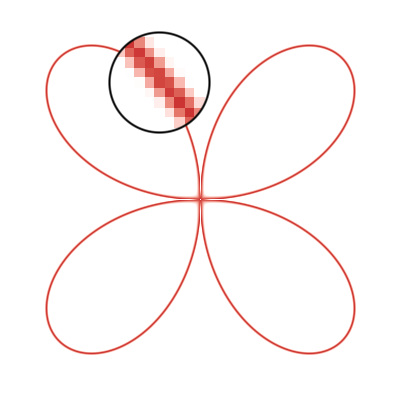

In [31]:
function roseBorder(i,j,w,h)
    (x,y) = xy(i,j,w,h)
    dxy_dij = dxy(i,j,w,h)
    r = rose(x,y)  ## r==0 defines the boundary of the shape
    dr_dxy = [drose_dx(x,y) ; drose_dy(x,y)]
    dr_dij = dxy_dij*dr_dxy
    r_in_pix = r/norm(dr_dij)
    borderSize = 2.0/2.0
    color = mix(foreground,background,smoothstep(borderSize-1.0, borderSize+1.0, abs(r_in_pix))) 
end

@> roseBorder begin
    zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage
end

## Better (but not perfect) -- but let's move on for now. 

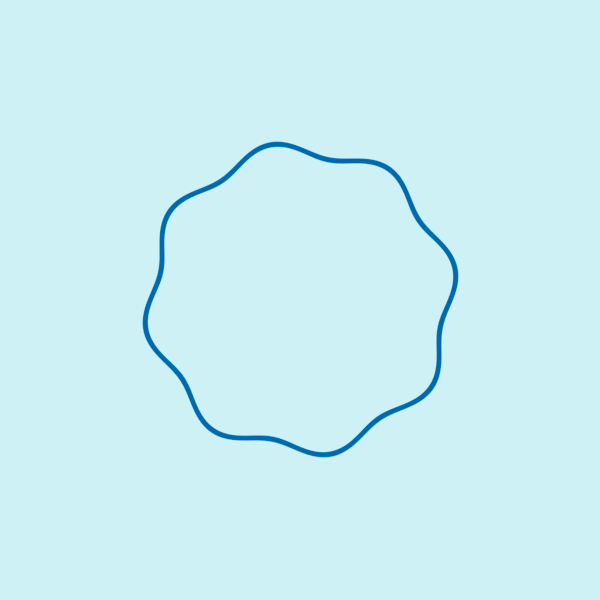

In [33]:
function border(r0,r1,d) ##units are pixels
    ## smooth version of r0 <= d  r1
    smoothstep(r0-1.0,r0+1.0,d) - smoothstep(r1-1.0,1.0+r1,d)
end

function wavyCircle(;numReps=10,radius=0.75,wiggle=0.3)

    background=LCHab➜LAB([93.0,12.0,210.0])
    foreground=LCHab➜LAB([40.0,50.0,255.0])
    
    (i,j,w,h)-> begin
        (x,y) = xy(i,j,w,h)
        dxy_dij = dxy(i,j,w,h)
        r = hypot(x,y)  
        c = x/r
        s = y/r
        dr_dx = c 
        dr_dy = s
        θ = atan(y,x)
        dθ_dx = -s
        dθ_dy = c
        borderSize = 5.0/2.0
        color = background
        ϕ = 0.0 # phase
        δ = r - radius*(1.0 + 0.5*wiggle*sin(θ*numReps+ϕ)) ## δ==0 is boundary  
        c_wig  = cos(θ*numReps+ϕ)   ## helper for calculating dδ
        dδ_dx  = dr_dx - 0.5*radius*wiggle*c_wig*dθ_dx 
        dδ_dy  = dr_dy - 0.5*radius*wiggle*c_wig*dθ_dy
        dδ_dij = dxy_dij * [dδ_dx;dδ_dy]
        dist_in_pix = abs(δ/norm(dδ_dij))
        alpha = border(-Inf, borderSize,dist_in_pix)
        color = mix(color,foreground,alpha)
        color 
    end
    
end

@> wavyCircle(numReps=8,wiggle=0.1,radius=0.5) begin
    ##zoomPixels(center=[265,388], radius=50, scale=10.0) 
    createImage(600,600)
end


===================================


# Take a Big Leap

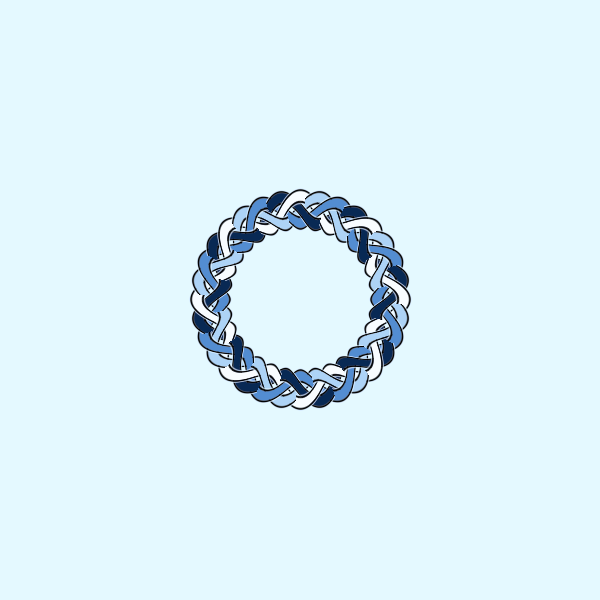

In [36]:
function braid(;strands=6,numReps=10,radius=0.75,wiggle=0.3,borderWidth=10.0,blackWidth=2.0,spaceWidth=1.0)

    background=LCHab➜LAB([97.0,12.0,255.0])
    function strandColors(hue,num)
            pal=sequential_palette(hue,num)
            colors=[convert(Lab,rgb) for rgb=pal]
            [[l.l, l.a, l.b] for l=colors]
    end
    colors = strandColors(255.0,strands)
    
    (i,j,w,h)-> begin
        (x,y) = xy(i,j,w,h)
        dxy_dij = dxy(i,j,w,h)
        r = hypot(x,y)  
        c = x/r
        s = y/r
        dr_dx = c 
        dr_dy = s
        θ = atan(y,x)
        dθ_dx = -s
        dθ_dy = c
        borderSize = borderWidth/2.0
        color = background
        offset= floor(θ/(2π/(strands*numReps)) + 1/strands)
        for ii=1:strands
            index=convert(Int,mod(ii+offset,strands)+1)
            ϕ = 2π*index/strands
            δ = r - radius*(1.0 + 0.5*wiggle*sin(θ*numReps+ϕ)) ## δ==0 is boundary  
            c_wig  = cos(θ*numReps+ϕ)
            dδ_dx  = dr_dx - 0.5*radius*wiggle*c_wig*dθ_dx
            dδ_dy  = dr_dy - 0.5*radius*wiggle*c_wig*dθ_dy
            dδ_dij = dxy_dij * [dδ_dx;dδ_dy]
            dist_in_pix = abs(δ/norm(dδ_dij))
            alpha = border(-Inf, borderSize,dist_in_pix)
            color = mix(color,colors[index],alpha)
            alpha = alpha = border(borderSize,borderSize+blackWidth,dist_in_pix)
            color = mix(color,[0.0,0.0,0.0],alpha)
            alpha = alpha = border(borderSize+blackWidth,borderSize+blackWidth+spaceWidth,dist_in_pix)
            color = mix(color,background,alpha)
        end
        color 
    end
    
end

@> braid(strands=4,numReps=8,wiggle=0.3,radius=0.3) begin
    ## zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage(600,600)
end

## Tear down it all, showing the steps in reverse

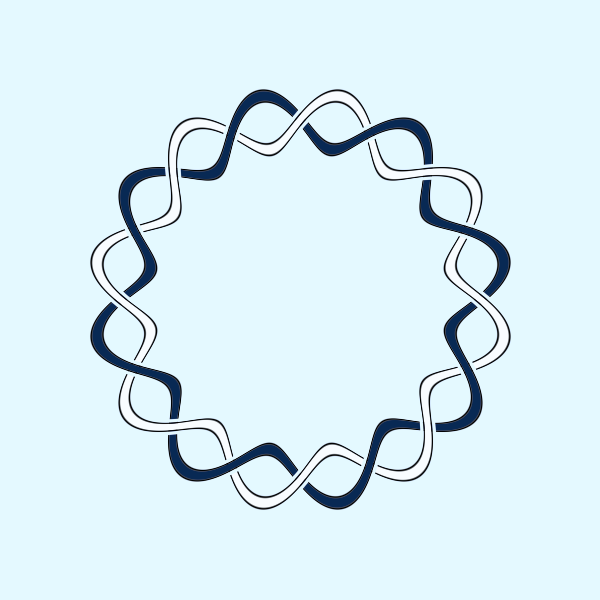

In [37]:
@> braid(strands=2,numReps=8,wiggle=0.3,radius=0.6,borderWidth=10.0, spaceWidth=5.0, blackWidth=2.0) begin
    ## zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage(600,600)
end

## Tear it down further

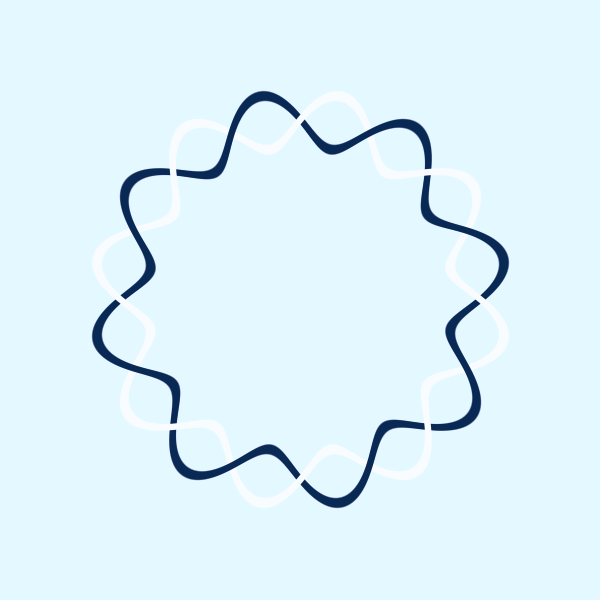

In [38]:
@> braid(strands=2,numReps=8,wiggle=0.3,radius=0.6,borderWidth=10.0, spaceWidth=0.0, blackWidth=0.0) begin
    ## zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage(600,600)
end

# The whole point of all of this


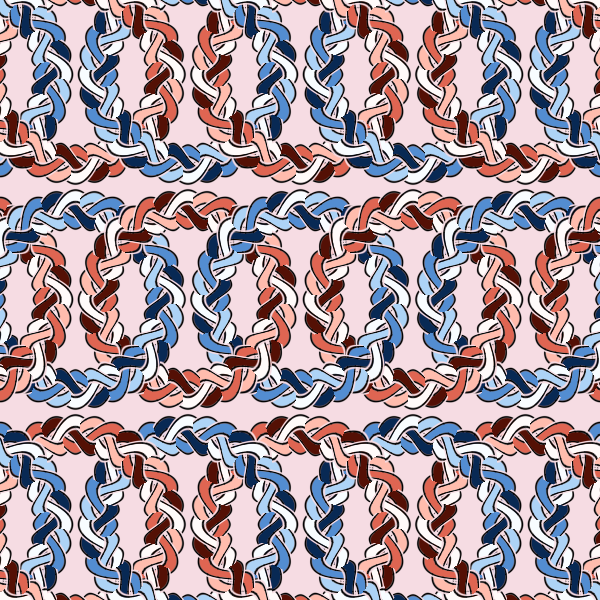

In [21]:
function borderw(r0,width,d) ##units are pixels
    border(r0,r0+width,d)
end

function linkedBraids(;strands=6,numReps=10,radius=0.75,wiggle=0.3,borderWidth=10.0,blackWidth=2.0,spaceWidth=2.0)

    background=LCHab➜LAB([90.0,10.0,0.0])
    function strandColors(hue,num)
            pal=sequential_palette(hue,num)
            colors=[convert(Lab,rgb) for rgb=pal]
            [[l.l, l.a, l.b] for l=colors]
    end
    colors = [strandColors(255.0,strands),strandColors(15.0, strands)]
    
    (i,j,w,h)-> begin
        spacing=(1+wiggle/2.0+0.1)*radius
        (x0,y0) = xy(i,j,w,h)
        dxy_dij = dxy(i,j,w,h)
        color = background
        layerOffset=[spacing;0.0]
        gridX=floor(x0/spacing+0.25)
        gridY=floor(y0/spacing)
        
        for l=0:1
            layer=convert(Int,mod(l+gridX+gridY,2))
            cls=colors[layer+1]
            x = x0 + layer*layerOffset[1] + mod(floor(y0/(2*spacing)+0.5),2)*spacing
            y = y0 + layer*layerOffset[2]
            x = mod(x + spacing,2.0*spacing)-spacing
            y = mod(y + spacing,2.0*spacing)-spacing

            r = hypot(x,y)  
            c = x/r
            s = y/r
            dr_dx = c 
            dr_dy = s
            θ = atan2(y,x)
            dθ_dx = -s
            dθ_dy = c
            borderSize = borderWidth/2.0

            offset= floor(θ/(2π/(strands*numReps)) + 1/strands)
            for ii=1:strands
                index=convert(Int,mod(ii+offset,strands)+1)
                ϕ = 2π*index/strands
                δ = r - radius*(1.0 + 0.5*wiggle*sin(θ*numReps+ϕ)) ## δ==0 is boundary  
                c_wig  = cos(θ*numReps+ϕ)
                dδ_dx  = dr_dx - 0.5*radius*wiggle*c_wig*dθ_dx
                dδ_dy  = dr_dy - 0.5*radius*wiggle*c_wig*dθ_dy
                dδ_dij = dxy_dij * [dδ_dx;dδ_dy]
                dist_in_pix = abs(δ/norm(dδ_dij))
                color = @>> border(-Inf, borderSize,dist_in_pix) mix(color,cls[index])
                color = @>> borderw(borderSize,blackWidth,dist_in_pix) mix(color,[0.0,0.0,0.0])
                color = @>> borderw(borderSize+blackWidth,spaceWidth,dist_in_pix) mix(color,background)            
            end
        end
        color 
    end
    
end

@> linkedBraids(strands=4,numReps=8,wiggle=0.3,radius=0.3,spaceWidth=2.0) begin
    ## zoomPixels(center=[160,318], radius=50, scale=10.0) 
    createImage(600,600)
end

=================================================

Questions for the reader: 
1. Is this a raster or vector image?
2. How would you have done this using traditional vector primitives?  

